In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pickle

In [2]:
def OLS(X,y,single=False):
    d=X.shape[1]
    inv_m=np.linalg.inv(X.T@X+0.001*np.identity(d))
    
    ols_vec=inv_m@X.T@y    ## (d,1) vector
    if single:
        std=sigma*inv_m[0,0]**0.5
        return ols_vec[0,0],std
    
        
    return ols_vec


def COLS(X,y,single=False):   ##centered OLS
    d=X.shape[1]
    
    X=X-np.ones((X.shape[0],1))@(np.mean(X,axis=0)).reshape(1,-1)
    
    inv_m=np.linalg.inv(X.T@X+0.001*np.identity(d))
    
    ols_vec=inv_m@X.T@y    ## (d,1) vector
    if single:
        std=sigma*inv_m[0,0]**0.5
        return ols_vec[0,0],std
    
        
    return ols_vec

def gen_data(n,d_all,d_ada,sigma, Xmean = 0):       
    
    # initialize theta_star
    theta_star=np.zeros((d_all,1))
    
    theta_star[0,0]=1
    theta_star[1:d_ada,0]=np.random.normal(loc=0,scale=1,size=(d_ada-1,))
    
    # non-zero non-adaptive coefficients
    theta_star[d_ada:,0]=np.random.normal(loc=0,scale=1,size=(d_all-d_ada,))
    

    X=np.zeros((n,d_all))
    y=np.zeros((n,1))
    eps=np.random.normal(loc=0,scale=sigma,size=(n,))
    

    # generate non-adaptive components with fixed norm
    X[:,d_ada:] = np.random.normal(loc=0,scale=1,size=(n,d_all-d_ada))
    X[:,d_ada:] = X[:,d_ada:] / np.linalg.norm(X[:,d_ada:],axis=1).reshape(n,1)
    
    if Xmean != 0:
        mu = np.random.normal(1,1,d_all - d_ada)
        X[:,d_ada:] = X[:,d_ada:] + np.ones((n, 1))@mu.reshape(1,-1)


    b=np.zeros(n+1)
    for i in range (n+1):
        b[i]=1/(i+1)**(1/4)/d_ada**0.5

    for i in range(n):
            
        v = i//(d_ada-1)
        u = i %(d_ada-1)
        
        X[i,u+1] = b[v]
        index_1 = np.arange(u,i,d_ada-1)
        assert np.size(index_1) == v
        
        # modify the code here
        # replace theta_star by theta_hat
        v1 = np.sum(b[:v]*( y[index_1,0]-X[index_1,0] - X[index_1, d_ada:]@theta_star[d_ada:,:]) )
        v2 = 1+np.sum(b[:v]**2)

        X[i,0] =- b[v+1]*v1/v2
    
        y[i,0] = X[i:(i+1),:]@theta_star + eps[i]


    return X, y, theta_star


In [3]:
def estimation_ratio_wrap(n,d_list,d_all, sigma):
    length=d_list.shape[0]
    
    record_ols=np.zeros((length,2))
    record_cols=np.zeros((length,2))


    for ii in range(length):
        d_ada=d_list[ii]
        
        X, y, theta_star = gen_data(n,d_all,d_ada,sigma, Xmean = 0)
        record_ols[ii,0],record_ols[ii,1]= OLS(X,y,single=True)
        record_ols[ii,0] = np.copy(record_ols[ii,0])-theta_star[0,0]
        
        X,y, theta_star = gen_data(n,d_all,d_ada,sigma, Xmean = 1)
        record_cols[ii,0],record_cols[ii,1]= COLS(X,y,single=True)
        record_cols[ii,0] = np.copy(record_cols[ii,0])-theta_star[0,0]
    
    
    return record_ols,record_cols
    

In [4]:
n=1000

d_all= 300
d_list=np.arange(2, 200, 3)
num=np.size(d_list)

rep= 20
sigma=0.3 ## scale of the zero mean noise


record_ols=np.zeros((rep,num,2))
record_cols=np.zeros((rep,num,2))

In [5]:
seed=15

np.random.seed(seed)

for j in range(rep):
    record_ols[j,:,:], record_cols[j,:,:]=estimation_ratio_wrap(n,d_list,d_all,sigma)  

    
record_list=[record_ols,record_cols]    

with open("./n_{}_{}.pkl".format(n,'estimation_ratio'), "wb") as file:
    pickle.dump([[seed,n,d_list,d_all,rep,sigma,num],record_list], file)
    
    

In [6]:
def plot_est_err_ratio(n):
    
    with open("./n_{}_{}.pkl".format(n,'estimation_ratio'), "rb") as file:
        [seed,n,d_list,d_all,rep,sigma,num],record_list=pickle.load(file)
        
    record_ols,record_cols=record_list
    
    scale_ols=record_ols[:,:,0]/record_ols[:,:,1]
    scale_cols=record_cols[:,:,0]/record_cols[:,:,1]
    scale_ols=np.abs(scale_ols)
    scale_cols=np.abs(scale_cols)


    
      
    plt.figure(figsize=(10,8))
    plt.rcParams.update({'font.size': 25})
    
    color_ols = 'navy'
    color_cols = 'forestgreen'



    
    title_fontsize = 25
    label_fontsize = 25
    capsize=3
    linewidth=2



    ''' color options
        'navy'
        'darkorange'
        'forestgreen'
        'darkviolet'
        'firebrick'
        'dodgerblue'
    '''
    
    plt.figure()    
    rep = np.size(d_list)
    plt.errorbar(d_list, np.mean(scale_ols**2,axis=0), yerr=np.std(scale_ols**2,axis=0), linestyle='-', marker='o', label='OLS',\
                        color=color_ols, capsize=capsize,linewidth=linewidth)

    x = d_list
    y = np.mean(scale_ols**2,axis=0)
    a, b = np.polyfit(x, y, 1)
    print(a)
    plt.plot(x, a*x+b, linewidth=2, color = 'black')  
       
    plt.xlabel('Dimension of adaptive covariates',fontsize=label_fontsize)
    plt.ylabel('Scaled MSE',fontsize=label_fontsize)
    plt.grid(True)
    plt.legend(fontsize=label_fontsize)
    
    

    # Show the plot
    plt.savefig('./zero_mean_OLS.pdf', bbox_inches='tight')
    plt.figure() 
    
    
    
    plt.errorbar(d_list, np.mean(scale_cols**2,axis=0), yerr=np.std(scale_cols**2,axis=0) , linestyle='--', marker='^', label='COLS',\
                         color=color_cols, capsize=capsize,linewidth=linewidth)
    
    x = d_list
    y = np.mean(scale_cols**2,axis=0)
    a, b = np.polyfit(x, y, 1)
    print(a)
    plt.plot(x, a*x+b, linewidth=3, color = 'black')  
       
    plt.xlabel('Dimension of adaptive covariates',fontsize=label_fontsize)
    plt.ylabel('Scaled MSE',fontsize=label_fontsize)
    plt.grid(True)
    plt.legend(fontsize=label_fontsize)
    
    
    # Show the plot
    plt.savefig('./non_zero_mean_COLS.pdf', bbox_inches='tight')
    plt.figure()

    

0.3147846586333958
0.30807150106950626


<Figure size 720x576 with 0 Axes>

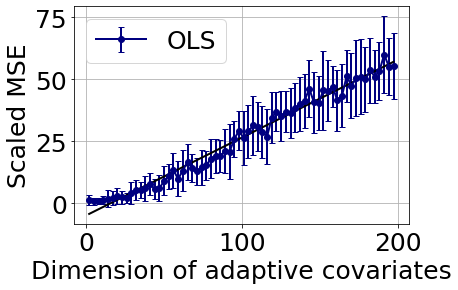

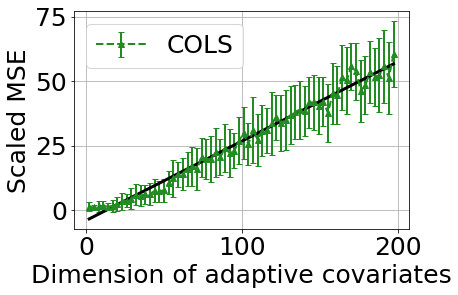

<Figure size 432x288 with 0 Axes>

In [7]:
plot_est_err_ratio(n)